# Data Preparation

## 1 Setup

In [1]:
from scipy import stats
import time
import numpy as np
import pandas as pd
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from idstools._config import load_config
from idstools._objects import Target
from idstools.preparation import DataPreparation
from idstools.optimization import ModelOptimization
%matplotlib inline

## 2 Import der Daten

Um den Testdatensatz vorzubereiten, hier einfach `test` statt `train` einsetzen.

In [2]:
file_to_prepare = "train"

In [3]:
data = pd.read_csv(f"../data/BikeRentalDaily_{file_to_prepare}.csv", sep=";", index_col=0)

## 3 Minimal Preprocessing

Während unserer ersten Analysen in Task 1 ist uns aufgefallen, dass die Variablen `season` und `hum` fehlende Werte aufweisen. Als Default-Methode und im Sinne von Minimal Preprocessing sollen die Zeilen mit fehlenden Werten entfernt werden.
Optionale Methoden zum Umgang mit fehlenden Werten werden im weiteren Verlauf addressiert.

In [4]:
data = data.dropna()

## 4 Baseline Linear Regression Model

Die Summe von `casual` und `registered` ergibt `cnt`, daher entfernen wir diese Spalten aus dem Datensatz. Zudem wird die Spalte `dteday` sowie das y_label von der Features-Liste entfernt.

temp entfernen

In [5]:
def baseline_linreg(data):
    data = data.dropna()
    y_label = 'cnt'
    features = data.drop(columns=[y_label, 'dteday', 'casual', 'registered']).columns
    X = data[features]
    y = data[y_label]
    X_train, X_validation, y_train, y_validation = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    random_state=42)
    reg = LinearRegression()
    reg.fit(X_train, y_train)
    y_pred = reg.predict(X_validation)
    r2 = r2_score(y_validation, y_pred).round(2)
    mae = mean_absolute_error(y_validation, y_pred).round(2)

    print(f'R2 Score: {r2}')
    print(f'Mean Absolute Error: {mae}')
    print("\nFeature Coefficients:")
    for coef, feature in zip(reg.coef_, X.columns):
        print(feature, abs(round(coef, 2)))
    return reg

In [6]:
baseline_linreg(data)

R2 Score: 0.2
Mean Absolute Error: 1347.57

Feature Coefficients:
season 393.16
yr 2428.07
mnth 46.68
holiday 953.4
weekday 189.94
workingday 639.12
weathersit 990.93
temp 3.75
atemp 6840.86
hum 1.71
windspeed 528.73
leaflets 1.2
price reduction 36.04


LinearRegression()

## 5 Other Options for Missing Value Handling

Wie wir bereits in Task 1 erarbeitet haben, weisen die Spalten `season` und `hum` fehlende Werte auf. Im ersten Schritt haben wir diese Zeilen entfernt. Nun wollen wir die fehlenden Werte imputieren.

In [7]:
data = pd.read_csv(f"../data/BikeRentalDaily_{file_to_prepare}.csv", sep=";", index_col=0)

<Axes: >

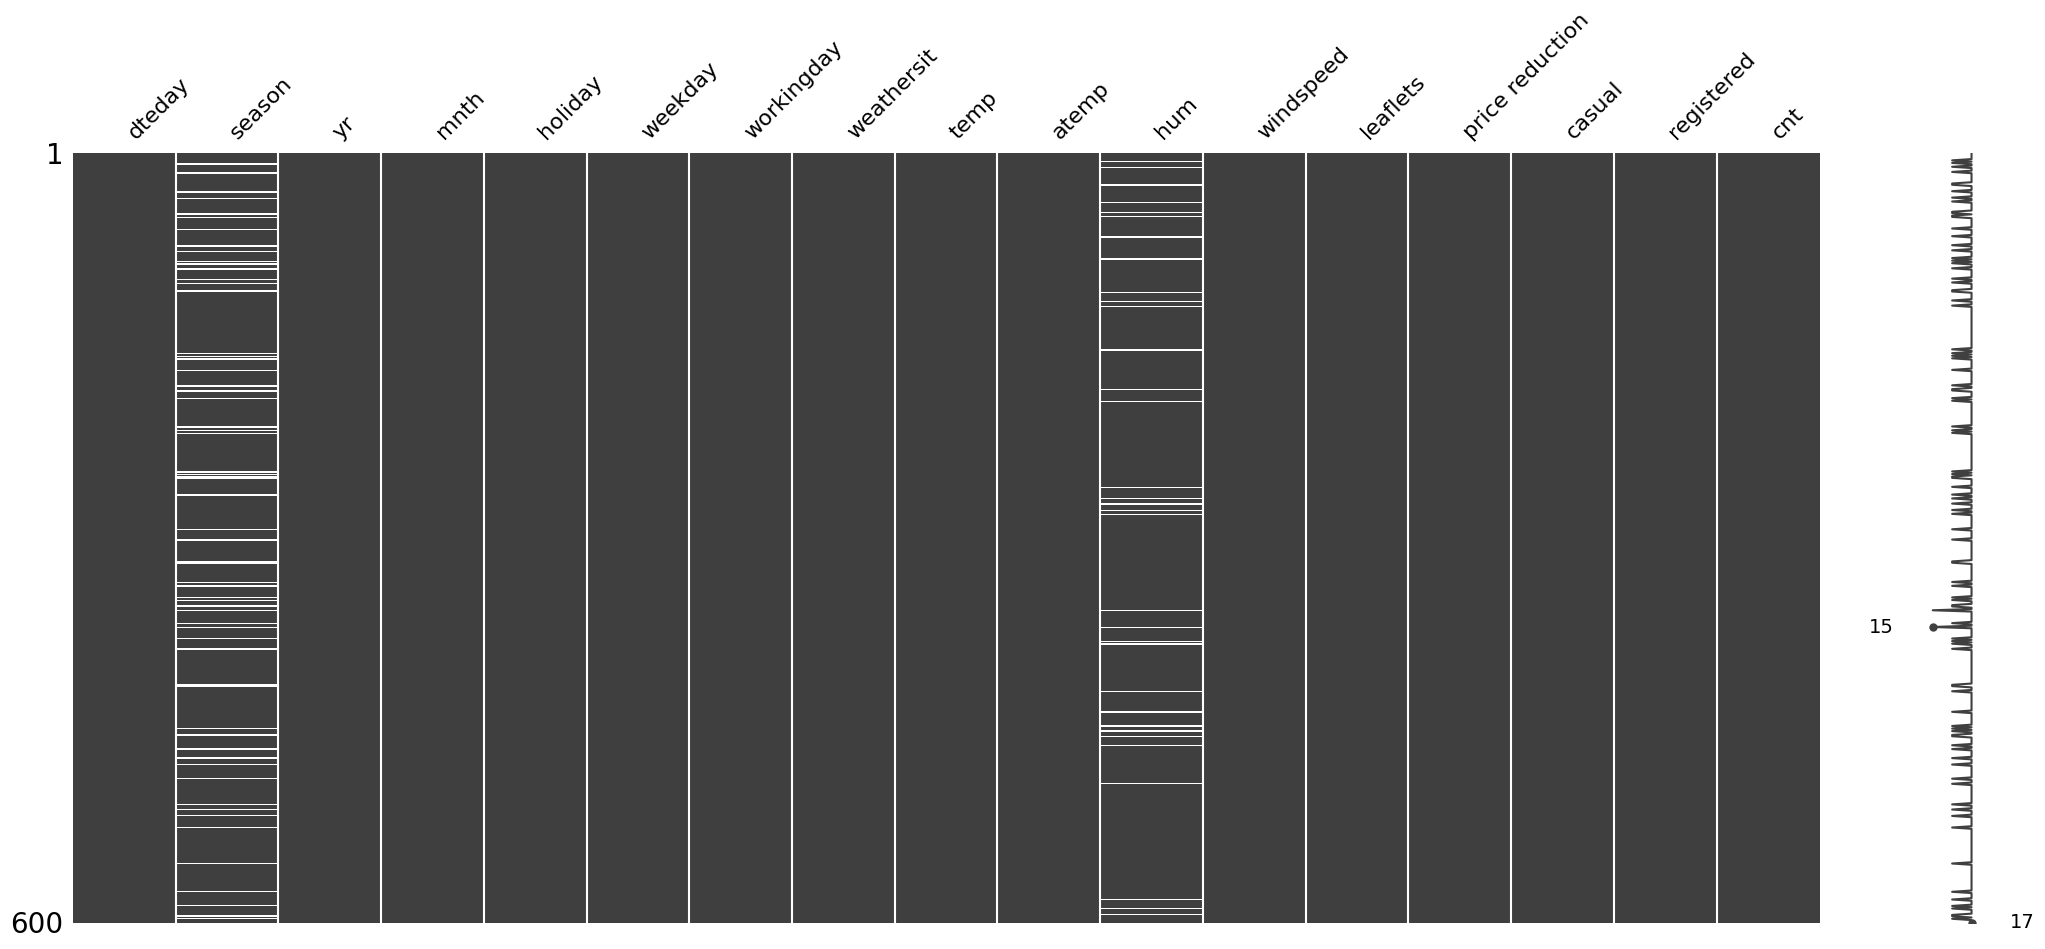

In [8]:
msno.matrix(data)

Die fehlenden Werte in der Spalte `season` werden anhand des vorliegenden Datums in der entsprechenden Zeile aufgefüllt. 

`get_season_by_date` bestimmt die Jahreszeit anhand eines Datums im Format "dd.mm". Sie verwendet das Modul time, um feste Zeitpunkte für den Beginn der Jahreszeiten (Frühling, Sommer, Herbst, Winter) festzulegen und vergleicht dann das eingegebene Datum mit diesen Zeitpunkten. Die Funktion gibt eine Ganzzahl zurück, die die entsprechende Jahreszeit repräsentiert (1 für Frühling, 2 für Sommer, 3 für Herbst, 4 für Winter). Beachte jedoch, dass die Funktion Schwierigkeiten mit dem 29. Februar haben könnte, wenn keine Jahreszahl angegeben ist, da sie die Schaltjahre nicht berücksichtigt.
Es gibt vier fest definierte Zeitpunkte für den Beginn jeder Jahreszeit (Frühling, Sommer, Herbst, Winter). Diese Zeitpunkte sind auf den 20. März, 20. Juni, 20. September und 20. Dezember festgelegt.

In [9]:
# datetime.datetime kann nicht mit 29. Feb umgehen, wenn keine Jahreszahl dabei ist
def get_season_by_date(date: str):
    """Derive season by date"""
    dateformat = "%d.%m"

    # Season beginnings
    spring = time.strptime("20.03", dateformat)
    summer = time.strptime("20.06", dateformat)
    autumn = time.strptime("20.09", dateformat)
    winter = time.strptime("20.12", dateformat)

    date_p = time.strptime(date[:5], dateformat)

    if date_p < spring:
        return 1
    elif spring < date_p < summer:
        return 2
    elif summer < date_p < autumn:
        return 3
    elif autumn < date_p < winter:
        return 4
    else:
        return 1

In [10]:
def season_wrapper(row):
    row["season"] = get_season_by_date(row["dteday"])
    return row
data = data.apply(season_wrapper, axis=1)
data

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,leaflets,price reduction,casual,registered,cnt
instant,,,,,,,,,,,,,,,,,
154,03.06.2011,2,0,6,0,5,1,1,24.8000,0.587133,53.12505,0.253121,991,0,898,4414,5312
685,15.11.2012,4,1,11,0,4,1,2,12.8667,0.324492,93.06255,0.152987,601,0,320,5125,5445
368,03.01.2012,1,1,1,0,2,1,1,6.0000,0.126275,66.18750,0.365671,549,0,89,2147,2236
472,16.04.2012,2,1,4,1,1,0,1,26.5667,0.614925,84.25005,0.284829,740,0,1198,5172,6370
442,17.03.2012,1,1,3,0,-1,0,2,20.5667,0.505046,113.37495,0.110704,773,1,3155,4681,7836
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,19.03.2011,1,0,3,0,6,0,1,18.9000,0.466525,56.87505,0.368167,1022,1,1424,1693,3117
81,22.03.2011,2,0,3,0,2,1,1,17.6667,0.440642,93.68745,0.225750,551,0,460,2243,2703
377,12.01.2012,1,1,1,0,4,1,2,15.3000,0.381938,120.43755,0.180967,520,0,269,3828,4097


Build a Linear Regression Model

In [11]:
baseline_linreg(data)

R2 Score: 0.27
Mean Absolute Error: 1123.97

Feature Coefficients:
season 583.2
yr 2408.12
mnth 35.44
holiday 1064.65
weekday 186.89
workingday 403.29
weathersit 711.04
temp 250.43
atemp 18324.23
hum 4.52
windspeed 100.36
leaflets 0.43
price reduction 455.36


LinearRegression()

Fehlende Werte in der Spalte `hum` werden durch den Mittelwert ersetzt. Wir haben auch ausprobiert die fehlenden Werte durch den Median zu ersetzen. Dies hat aber zu keinen nennenswerten Unterschieden oder Verbesserungen geführt.

In [12]:
data["hum"] = data["hum"].fillna(np.mean(data["hum"]))

<Axes: >

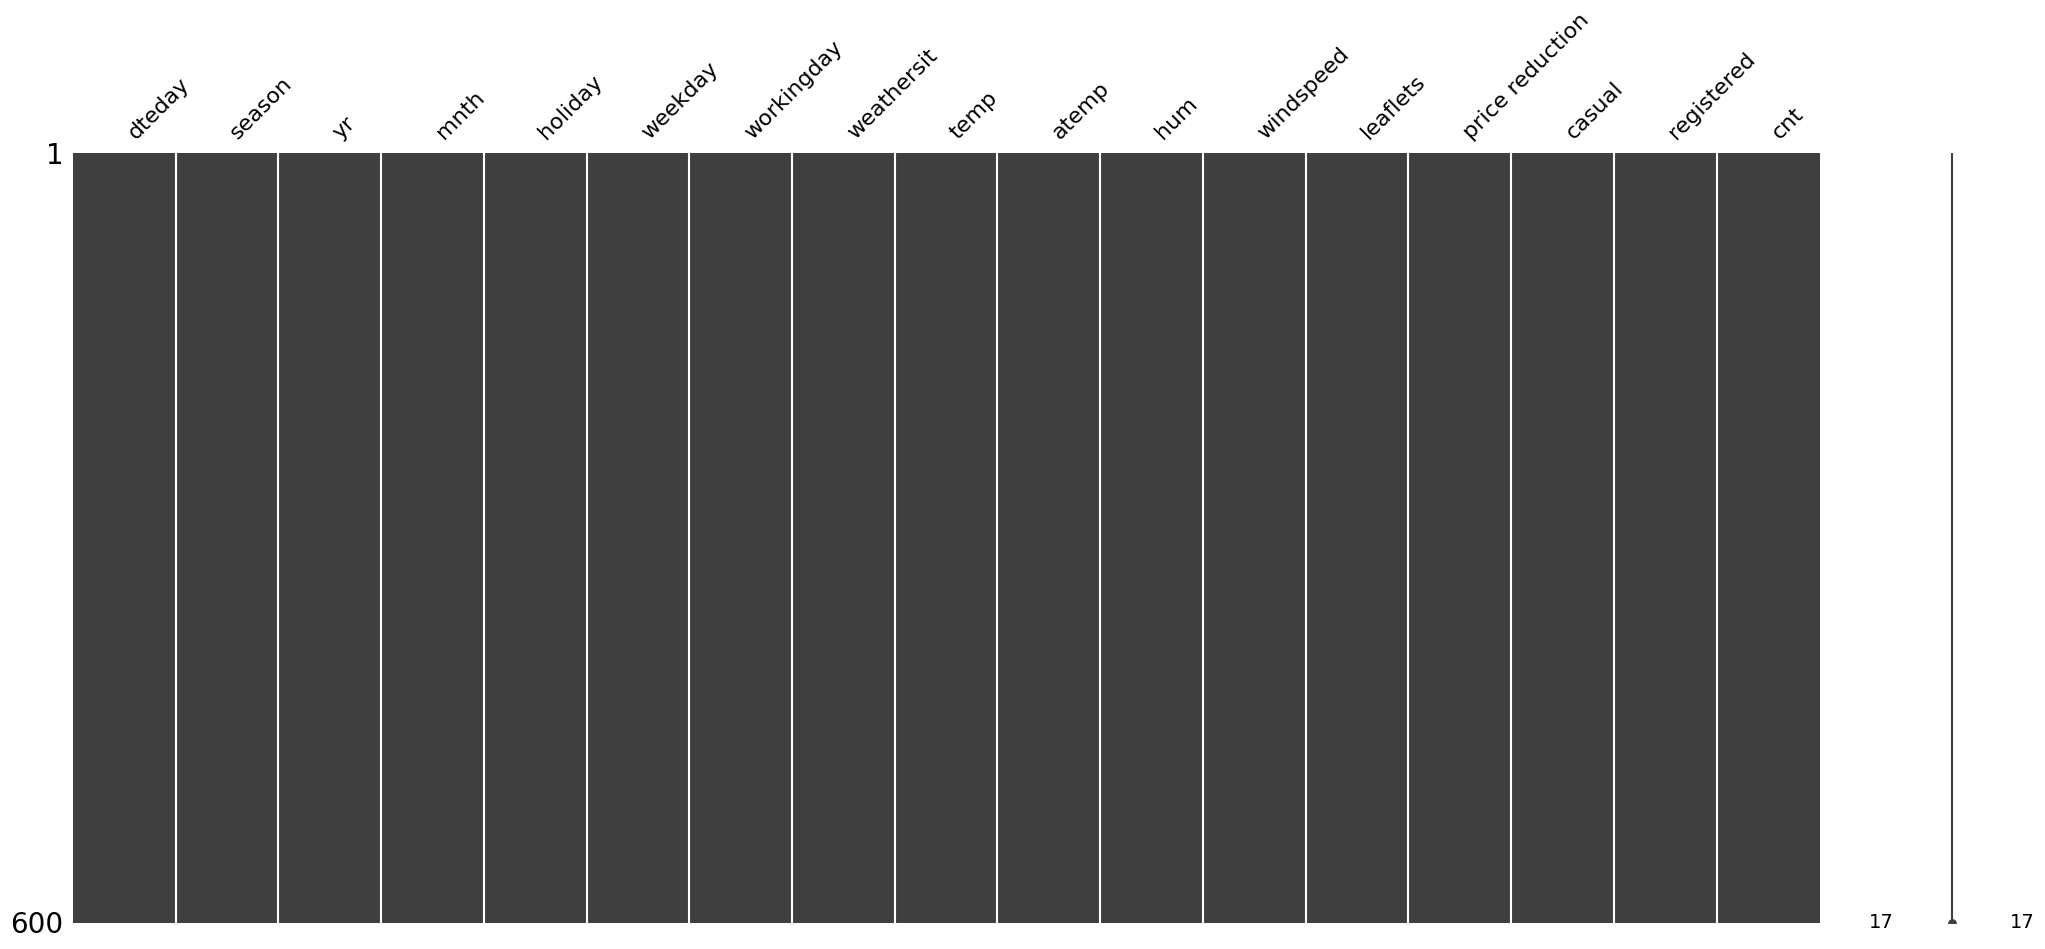

In [13]:
msno.matrix(data)

In [14]:
baseline_linreg(data)

R2 Score: 0.23
Mean Absolute Error: 1306.85

Feature Coefficients:
season 602.86
yr 2318.34
mnth 18.25
holiday 913.85
weekday 152.09
workingday 377.97
weathersit 973.54
temp 7.02
atemp 7068.58
hum 3.62
windspeed 424.14
leaflets 1.24
price reduction 17.78


LinearRegression()

## 6 Data Corrections

Aus der deskriptiven Statistik ist ersichltich, dass das Minimum der Variable "windspeed" bei -1 liegt. Da die Windgeschwindigkeit nicht negativ sein kann, treffen wir die Annahme, dass es sich hierbei um Fehler handeln muss. Zunächst identifizieren wir hierfür die entsprechenden Zeilen.

In [15]:
negative_rows_windspeed = data[data['windspeed'] < 0].index

negative_rows_windspeed

Index([197, 155, 224, 236], dtype='int64', name='instant')

In [16]:
negative_rows = data.loc[data['windspeed'] < 0]

print(negative_rows)

             dteday  season  yr  mnth  holiday  weekday  workingday  \
instant                                                               
197      16.07.2011       3   0     7        0        6           0   
155      04.06.2011       2   0     6        0        6           0   
224      12.08.2011       3   0     8        0        5           1   
236      24.08.2011       3   0     8        0        3           1   

         weathersit     temp     atemp      hum  windspeed  leaflets  \
instant                                                                
197               1  27.4667  0.638263  87.7500       -1.0       731   
155               1  25.4000  0.594696  68.4375       -1.0       624   
224               1  28.3333  0.654042  62.2500       -1.0       835   
236               1  26.9333  0.630692  90.7500       -1.0       935   

         price reduction  casual  registered   cnt  
instant                                             
197                    0    2418  

Hier würde sich ggf. eine Regression Imputation zum Auffüllen der vier fehlenden Werte anbieten. Aus der Correlation Matrix sehen wir aber, dass `windspeed` kaum mit anderen Features korreliert. Aus diesem Grund entfernen wir die Werte.

Im Anschluss entfernen wir die entsprechenden vier Zeilen aus dem Dataframe.

In [17]:
data = data.drop(negative_rows_windspeed)

Der Wochentag `-1` ist offensichtlich ein fehlender Wert, der ebenfalls behoben werden muss.

In [18]:
def get_wday_by_date(row):
    if row["weekday"] > 0:
        return row
    weekday_shift = { # week starts on Sunday in dataset
        6: 0,
        0: 1,
        1: 2,
        2: 3,
        3: 4,
        4: 5,
        5: 6
    }
    dateformat = "%d.%m.%Y"
    row["weekday"] = weekday_shift[time.strptime(row["dteday"], dateformat).tm_wday]
    return row
data = data.apply(get_wday_by_date, axis=1)

In [19]:
baseline_linreg(data)

R2 Score: 0.29
Mean Absolute Error: 991.47

Feature Coefficients:
season 635.76
yr 2367.36
mnth 50.65
holiday 833.15
weekday 210.07
workingday 295.31
weathersit 795.63
temp 23.77
atemp 5760.21
hum 2.68
windspeed 260.12
leaflets 0.61
price reduction 349.85


LinearRegression()

## 7 Outlier Detection and Handling

Es ist zu sehen, dass die Gesamtanzahl und die Zahl der nicht registrierten Nutzer einen sehr hohen Maximalwert haben. Die Gesamtzahl wird aus registrierten Nutzern und nicht registrierten Nutzern hergeleitet. Die Outlier werden dann mittels der `casual` Spalte ermittelt.

In [20]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
season,596.0,2.442953,1.122018,1.000000,1.000000,2.000000,3.000000,4.000000
yr,596.0,0.500000,0.500420,0.000000,0.000000,0.500000,1.000000,1.000000
mnth,596.0,6.469799,3.453036,1.000000,4.000000,6.000000,9.000000,12.000000
holiday,596.0,0.030201,0.171285,0.000000,0.000000,0.000000,0.000000,1.000000
weekday,596.0,3.018456,2.002854,0.000000,1.000000,3.000000,5.000000,6.000000
workingday,596.0,0.681208,0.466400,0.000000,0.000000,1.000000,1.000000,1.000000
weathersit,596.0,1.404362,0.543176,1.000000,1.000000,1.000000,2.000000,3.000000
temp,596.0,19.759794,7.206026,2.365200,13.491675,19.966650,26.000000,34.466700
atemp,596.0,0.472574,0.160457,0.079070,0.337891,0.487364,0.603868,0.826371
hum,596.0,93.956262,20.766061,28.187550,78.468712,93.845200,108.437550,145.875000


Da `cnt` die Summe aus `casual` und `registered` ist, werden beim Entfernen der Outlier von `casual` auch die Outlier von `cnt` entfernt.

In [21]:
zscores = stats.zscore(data["casual"])
thresh = 3.0
outliers = data[abs(zscores) > thresh]
outliers

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,leaflets,price reduction,casual,registered,cnt
instant,,,,,,,,,,,,,,,,,
631,22.09.2012,4,1,9,0,6,0,1,26.0000,0.610488,97.00005,0.283583,963,0,47138,5883,53021
505,19.05.2012,2,1,5,0,6,0,1,24.0000,0.566908,68.43750,0.083975,1030,0,38061,4884,42945
448,23.03.2012,2,1,3,0,5,1,2,24.0667,0.570067,104.12505,0.116300,535,1,26150,5893,32043
624,15.09.2012,3,1,9,0,6,0,1,24.3333,0.585867,75.25005,0.247521,820,0,30378,5554,35932


Diese Werte werden entfernt

In [22]:
data_no_out = data.drop(outliers.index, errors="ignore")

In [23]:
data_no_out.describe().T

,count,mean,std,min,25%,50%,75%,max
season,592.0,2.440878,1.123455,1.000000,1.000000,2.000000,3.000000,4.000000
yr,592.0,0.496622,0.500411,0.000000,0.000000,0.000000,1.000000,1.000000
mnth,592.0,6.469595,3.458101,1.000000,4.000000,6.000000,9.000000,12.000000
holiday,592.0,0.030405,0.171845,0.000000,0.000000,0.000000,0.000000,1.000000
weekday,592.0,3.000000,1.996613,0.000000,1.000000,3.000000,5.000000,6.000000
workingday,592.0,0.684122,0.465258,0.000000,0.000000,1.000000,1.000000,1.000000
weathersit,592.0,1.405405,0.543696,1.000000,1.000000,1.000000,2.000000,3.000000
temp,592.0,19.727090,7.219009,2.365200,13.458350,19.866650,26.008325,34.466700
atemp,592.0,0.471826,0.160733,0.079070,0.337628,0.483262,0.603868,0.826371
hum,592.0,94.008648,20.790878,28.187550,78.593775,93.845200,108.609413,145.875000


In [24]:
baseline_linreg(data_no_out)

R2 Score: 0.85
Mean Absolute Error: 635.41

Feature Coefficients:
season 437.27
yr 1911.56
mnth 31.56
holiday 642.34
weekday 49.97
workingday 156.65
weathersit 620.27
temp 82.55
atemp 2208.99
hum 8.55
windspeed 3279.14
leaflets 0.22
price reduction 151.15


LinearRegression()

## 8 Feature Transformation

### Dummies / One Hot Encoding ###

Für die Variablen `weekday` und `weathersit` erstellen wir mittels One Hot Encoding separate binäre Spalten für jede Ausprägung. Anschließend entfernen wir die ursprünglichen zwei Spalten.

In [25]:
data_d = pd.concat([data_no_out, pd.get_dummies(data_no_out["weekday"], prefix="weekday", dtype=int)], axis=1)
data_d = pd.concat([data_d, pd.get_dummies(data_no_out["season"], prefix="season", dtype=int)], axis=1)
data_d = pd.concat([data_d, pd.get_dummies(data_no_out["weathersit"], prefix="weathersit", dtype=int)], axis=1)
data_d.drop(columns=["weekday", "weathersit", "season"], inplace=True)

In [26]:
data_d

,dteday,yr,mnth,holiday,workingday,temp,atemp,hum,windspeed,leaflets,...,weekday_4,weekday_5,weekday_6,season_1,season_2,season_3,season_4,weathersit_1,weathersit_2,weathersit_3
instant,,,,,,,,,,,,,,,,,,,,,
154,03.06.2011,0,6,0,1,24.8000,0.587133,53.12505,0.253121,991,...,0,1,0,0,1,0,0,1,0,0
685,15.11.2012,1,11,0,1,12.8667,0.324492,93.06255,0.152987,601,...,1,0,0,0,0,0,1,0,1,0
368,03.01.2012,1,1,0,1,6.0000,0.126275,66.18750,0.365671,549,...,0,0,0,1,0,0,0,1,0,0
472,16.04.2012,1,4,1,0,26.5667,0.614925,84.25005,0.284829,740,...,0,0,0,0,1,0,0,1,0,0
442,17.03.2012,1,3,0,0,20.5667,0.505046,113.37495,0.110704,773,...,0,0,1,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,19.03.2011,0,3,0,0,18.9000,0.466525,56.87505,0.368167,1022,...,0,0,1,1,0,0,0,1,0,0
81,22.03.2011,0,3,0,1,17.6667,0.440642,93.68745,0.225750,551,...,0,0,0,0,1,0,0,1,0,0
377,12.01.2012,1,1,0,1,15.3000,0.381938,120.43755,0.180967,520,...,1,0,0,1,0,0,0,0,1,0


In [27]:
final_model = baseline_linreg(data_d)

R2 Score: 0.89
Mean Absolute Error: 516.17

Feature Coefficients:
yr 1895.74
mnth 15.89
holiday 519.03
workingday 290.75
temp 130.93
atemp 409.13
hum 9.67
windspeed 3331.42
leaflets 0.19
price reduction 130.18
weekday_0 15.6
weekday_1 125.54
weekday_2 143.96
weekday_3 5.5
weekday_4 9.73
weekday_5 56.45
weekday_6 243.89
season_1 733.8
season_2 148.31
season_3 136.88
season_4 722.37
weathersit_1 810.45
weathersit_2 383.36
weathersit_3 1193.81


## 9 Multicolinearity ##

In der Korrelationsmatrix ist zu sehen, dass die Variablen `hum` und `atemp`, und `temp` und `weathersit` eine starke Korrelation aufweisen. Dies kann später zu Problemen bei der Regression führen, daher werden nur `atemp` und `weathersit` behalten. Wir verwenden die gefühlte Temperatur, da diese zu einem Grad aus der tatasächlichen Temperatur und der Luftfeuchte hervorgeht.

In [28]:
#data_d.drop(columns=["hum", "temp"], inplace=True)
data_d.drop(columns=["temp"], inplace=True)

In [29]:
baseline_linreg(data_d)

R2 Score: 0.89
Mean Absolute Error: 508.81

Feature Coefficients:
yr 1913.07
mnth 14.86
holiday 492.73
workingday 285.71
atemp 5909.56
hum 9.39
windspeed 3017.5
leaflets 0.16
price reduction 131.91
weekday_0 26.88
weekday_1 139.87
weekday_2 141.15
weekday_3 3.57
weekday_4 15.1
weekday_5 85.54
weekday_6 233.9
season_1 793.11
season_2 146.78
season_3 23.68
season_4 670.02
weathersit_1 816.1
weathersit_2 376.22
weathersit_3 1192.32


LinearRegression()

Zuletzt exportieren wir das Datenset als CSV und speichern das Model.

In [30]:
data_d.to_csv(f"../data/prepared_{file_to_prepare}.csv", sep=";")

import pickle
filename = '../models/final_model.pkl'
pickle.dump(final_model, open(filename, 'wb'))
features = '../models/final_model_features.pkl'
pickle.dump(data_d.columns, open(features, 'wb'))

In [31]:
data_d.describe().T

,count,mean,std,min,25%,50%,75%,max
yr,592.0,0.496622,0.500411,0.000000,0.000000,0.000000,1.000000,1.000000
mnth,592.0,6.469595,3.458101,1.000000,4.000000,6.000000,9.000000,12.000000
holiday,592.0,0.030405,0.171845,0.000000,0.000000,0.000000,0.000000,1.000000
workingday,592.0,0.684122,0.465258,0.000000,0.000000,1.000000,1.000000,1.000000
atemp,592.0,0.471826,0.160733,0.079070,0.337628,0.483262,0.603868,0.826371
hum,592.0,94.008648,20.790878,28.187550,78.593775,93.845200,108.609413,145.875000
windspeed,592.0,0.191700,0.079411,0.022392,0.134953,0.181598,0.233947,0.507463
leaflets,592.0,739.131757,164.291185,459.000000,599.750000,736.000000,875.000000,1032.000000
price reduction,592.0,0.150338,0.357704,0.000000,0.000000,0.000000,0.000000,1.000000
casual,592.0,835.342905,681.859751,2.000000,309.750000,703.500000,1070.000000,3283.000000


Jetzt laden wir die Test Daten um das Model damit zu evaluieren.

In [32]:
test_data = pd.read_csv(f"../data/prepared_test.csv", sep=";", index_col=0)

final_model = pickle.load(open(filename, 'rb'))
final_model_features = pickle.load(open(features, 'rb'))

## 10 Task 2 - idstools ##

Parallel zu der schrittweisen Evaluierung des Baseline Models mit den Trainigsdaten, haben wir eine Pipeline erstellt, welche die einzelnen Schritte automatisiert ausführt.

Hierfür haben wir ein Framework entwickelt welches auf Basis von ```Target``` Objekten verschiedene Funktionen anwenden kann.

Im ersten Schritt initialisieren wir die beiden ```Target```Objekte für den Trainings- und Testdatenstatz. 

In [33]:
train_target = Target(
    id=1,
    input_path="data/BikeRentalDaily_train.csv",
    input_delimiter=";",
    label="cnt"
)
test_target = Target(
    id=2,
    input_path="data/BikeRentalDaily_test.csv",
    input_delimiter=";",
    label="cnt"
)

2024-03-02 16:05:58,782 [_objects] [INFO] - Initializing TargetData object.
2024-03-02 16:05:58,784 [_helpers] [INFO] - Reading data from:
/home/davidrmn/Studies/introduction-data-science/data/BikeRentalDaily_train.csv
2024-03-02 16:05:58,789 [_objects] [INFO] - Using id: 1
2024-03-02 16:05:58,791 [_objects] [INFO] - Using label: cnt
2024-03-02 16:05:58,791 [_objects] [INFO] - No index provided.
2024-03-02 16:05:58,792 [_objects] [INFO] - No features provided.
2024-03-02 16:05:58,793 [_objects] [INFO] - No environment name provided.
Using default environment name: SELF_EXECUTED
2024-03-02 16:05:58,793 [_objects] [INFO] - No step name provided.
2024-03-02 16:05:58,794 [_objects] [INFO] - Output path not provided.
Using default output path: /home/davidrmn/Studies/introduction-data-science/results
2024-03-02 16:05:58,795 [_objects] [INFO] - Initializing TargetData object.
2024-03-02 16:05:58,796 [_helpers] [INFO] - Reading data from:
/home/davidrmn/Studies/introduction-data-science/data/B

Danach laden wir die Konfiguration für Task 2.

In [34]:
config = load_config('../config/idstools/Task_2.yaml')

In dieser Konfiguration sind die beiden Pipelines für das Preprocessing und die anschließende Model Evaluierung enthalten.'

In [35]:
config

```yaml
DEFAULT: null
PREPROCESSING:
  pipeline:
    _CustomTransformer:
    - func: target_to_datetime
      module: idstools._transformer
      config:
        target: dteday
        format: '%d.%m.%Y'
    - func: impute_season
      module: idstools._transformer
      config:
        target: season
        date: dteday
    - func: negative_to_nan
      module: idstools._transformer
      config:
        target: windspeed
    - func: process_weekday
      module: idstools._transformer
      config:
        target: weekday
        date: dteday
    - func: remove_outliers
      module: idstools._transformer
      config:
        target: casual
    _OneHotEncoder:
    - target: season
      config:
        prefix: season
        dtype: int
        drop_first: true
    - target: weekday
      config:
        prefix: weekday
        dtype: int
        drop_first: true
    - target: weathersit
      config:
        prefix: weathersit
        dtype: int
        drop_first: true
    _NaNDropper:
    - target:
      - windspeed
    _SimpleImputer:
    - target:
      - hum
      config:
        strategy: mean
    _FeatureDropper:
    - target:
      - casual
      - registered
      - temp
      - dteday
      config:
        axis: 1
        errors: ignore
OPTIMIZATION:
  pipeline:
  - id: 1
    targets:
    - 1
    model: LinearRegression
    module: sklearn.linear_model
    split:
      config:
        test_size: 0.2
        random_state: 42
    validation:
      targets:
      - 2
      methods:
      - mae
      - r2_score

```

Im zweiten Schritt initialisieren wir das ```preparation``` Objekt. Diesem werden einerseites die beiden Training und Test Targets und andererseteits die Konfiguration der Preprocessing-Pipeline übergeben.

In [36]:
preparation = DataPreparation(targets=[train_target, test_target], pipeline=config.preprocessing.pipeline)

2024-03-02 16:05:58,875 [preparation] [INFO] - Initializing DataPreparation for multiple targets.


Die Preprocessing-Schritte werden durch aufrufen der ```run``` Methode auf die beiden Targets angewendet. 

In [37]:
preparation.run()

2024-03-02 16:05:58,889 [preparation] [INFO] - Pipeline created:
_CustomTransformer:
- func: target_to_datetime
  module: idstools._transformer
  config:
    target: dteday
    format: '%d.%m.%Y'
- func: impute_season
  module: idstools._transformer
  config:
    target: season
    date: dteday
- func: negative_to_nan
  module: idstools._transformer
  config:
    target: windspeed
- func: process_weekday
  module: idstools._transformer
  config:
    target: weekday
    date: dteday
- func: remove_outliers
  module: idstools._transformer
  config:
    target: casual
_OneHotEncoder:
- target: season
  config:
    prefix: season
    dtype: int
    drop_first: true
- target: weekday
  config:
    prefix: weekday
    dtype: int
    drop_first: true
- target: weathersit
  config:
    prefix: weathersit
    dtype: int
    drop_first: true
_NaNDropper:
- target:
  - windspeed
_SimpleImputer:
- target:
  - hum
  config:
    strategy: mean
_FeatureDropper:
- target:
  - casual
  - registered
  -

Im dritten und letzten Schritt wird das ```optimization``` Objekt initialisiert. Diesem werden wie im vorhergehenden Schritt die Targets und die Konfiguration der Evaluation-Pipeline übergeben.

In [38]:
optimization = ModelOptimization(targets=[train_target, test_target], pipeline=config.optimization.pipeline)

2024-03-02 16:05:59,025 [optimization] [INFO] - Initializing ModelOptimization


Die Evaluierung der in der Pipeline definierten Modelle, sowie Data splitting und anwenden der konfigurierten Validierungsmethoden werden durch ausführen der ```run``` Methode durchgeführt. 

Die Ergebnisse der Validierung werden im Target-Objekt gespeichert.

2024-03-02 16:05:59,079 [optimization] [INFO] - Running model optimization pipeline.
2024-03-02 16:05:59,081 [optimization] [INFO] - Retrieving model LinearRegression.
2024-03-02 16:05:59,081 [optimization] [INFO] - Preparing target for LinearRegression.
2024-03-02 16:05:59,084 [optimization] [INFO] - Performed splitting for BikeRentalDaily_train
Training set: 473 samples
Testing set: 119 samples
2024-03-02 16:05:59,085 [optimization] [INFO] - Fitting BikeRentalDaily_train for LinearRegression.
2024-03-02 16:05:59,087 [optimization] [INFO] - Prepare validation data BikeRentalDaily_test for 1.
2024-03-02 16:05:59,089 [optimization] [INFO] - Predicting target BikeRentalDaily_test for 1.
2024-03-02 16:05:59,155 [optimization] [INFO] - Validating model 1 with method mae.
2024-03-02 16:05:59,156 [optimization] [INFO] - Calculating mean absolute error for model 1.
2024-03-02 16:05:59,157 [optimization] [INFO] - Mean absolute error for model 1 with validation target BikeRentalDaily_test is 64

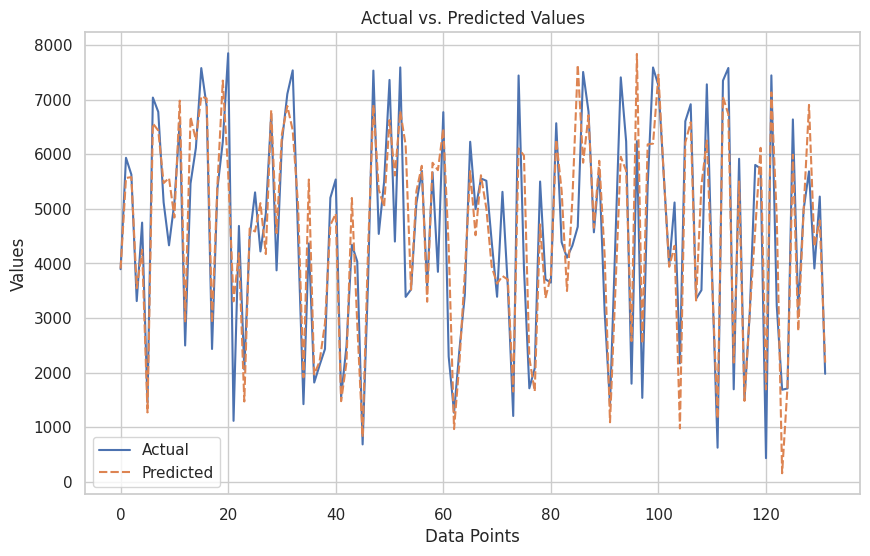

In [39]:
optimization.run()

Das Folgende Diagramm zeigt die Performance des Baseline Modells nach anwenden der Preprocessing Pipeline auf Basis der Testdaten in Form eines Liniendiagramms.

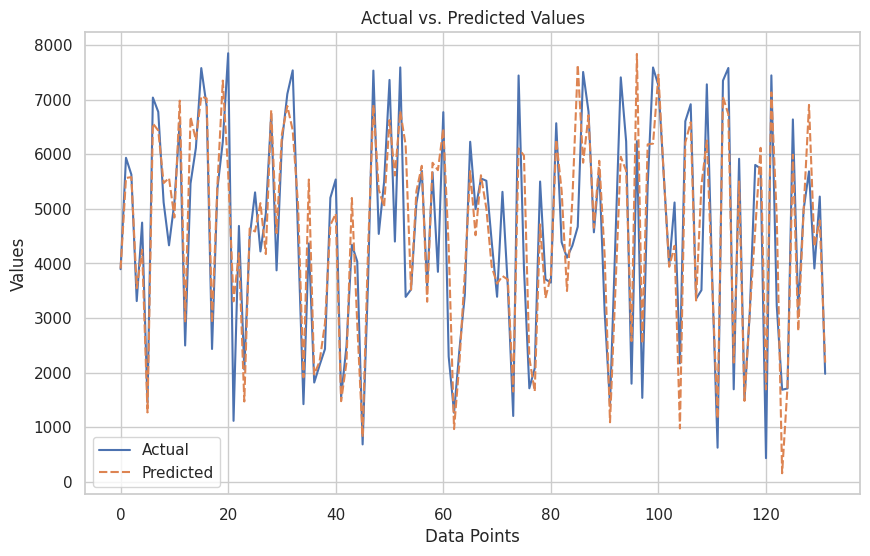

In [40]:
test_target.figures[1]['Actual_vs_Predicted']